# Quantum Key Distribution

## 1. Introducción

Cuando Alice y Bob quieren comunicar un mensaje secreto (como sus datos bancarios en línea) a través de un canal inseguro (como internet), es esencial cifrar el mensaje. Dado que la criptografía es un área extensa y casi toda queda fuera del alcance de este libro de texto, tendremos que creer que tener una clave secreta que nadie más conoce es útil y les permite comunicarse mediante criptografía de clave simétrica.

Si Alice y Bob quieren usar el canal de comunicación clásico de Eve para compartir su clave, es imposible saber si Eve ha hecho una copia de esta; deben confiar plenamente en que Eve no está escuchando. Sin embargo, si Eve proporciona un canal de comunicación cuántico, Alice y Bob ya no necesitan confiar en Eve en absoluto; sabrán si intenta leer el mensaje de Bob antes de que llegue a Alice.

Para algunos lectores, puede ser útil dar una idea de cómo se puede implementar físicamente un canal cuántico. Un ejemplo de un canal clásico podría ser una línea telefónica; a través de la línea enviamos señales eléctricas que representan nuestro mensaje (o bits). Un ejemplo propuesto de canal de comunicación cuántica podría ser algún tipo de cable de fibra óptica, a través del cual podemos enviar fotones individuales (partículas de luz). Los fotones tienen una propiedad llamada polarización, y esta polarización puede tener uno de dos estados. Podemos usar esto para representar un cúbit.

## 2. Resumen del protocolo

El protocolo aprovecha el hecho de que la medición de un cúbit puede cambiar su estado. Si Alice envía un cúbit a Bob y un espía (Eve) intenta medirlo antes que Bob, existe la posibilidad de que la medición de Eve cambie el estado del cúbit y Bob no reciba el estado del cúbit que Alice envió.

In [ ]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from numpy.random import randint
import numpy as np

Si Alice prepara un qubit en el estado $|+\rangle$ (`0` en la base $X$), y Bob lo mide en la base $X$, Bob estará completamente seguro de medir `0`:

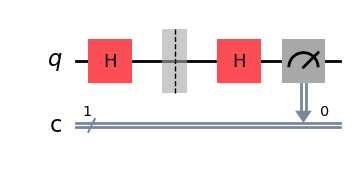

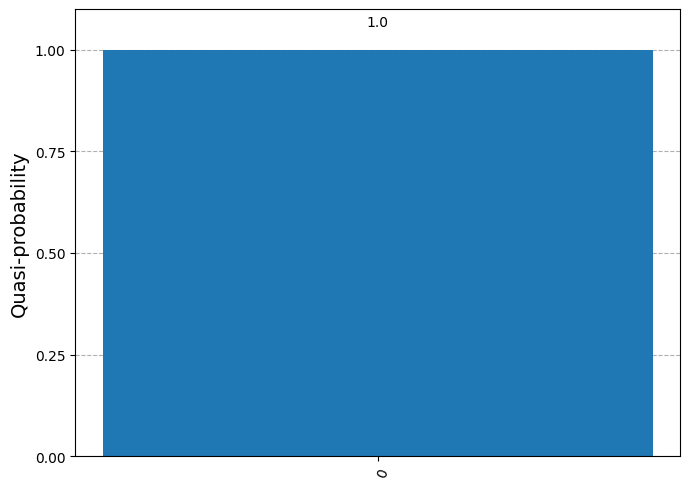

In [ ]:
qc = QuantumCircuit(1,1)
# Alice prepara qubit en estado |+>
qc.h(0)
qc.barrier()
# Alice ahora envía el cúbit a Bob
# quien lo mide en base X
qc.h(0)
qc.measure(0,0)

# Dibujar y simular el circuito
display(qc.draw('mpl'))
aer_sim = AerSimulator()
job = aer_sim.run(transpile(qc, aer_sim)).result()
plot_distribution(job.get_counts())

Pero si Eve intenta medir este qubit en la base $Z$ antes de que llegue a Bob, cambiará el estado del qubit de $|+\rangle$ a $|0\rangle$ o $|1\rangle$, y Bob ya no estará seguro de medir `0`:

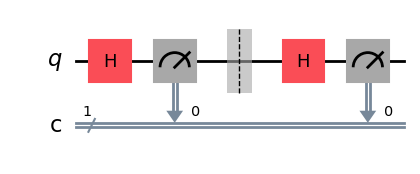

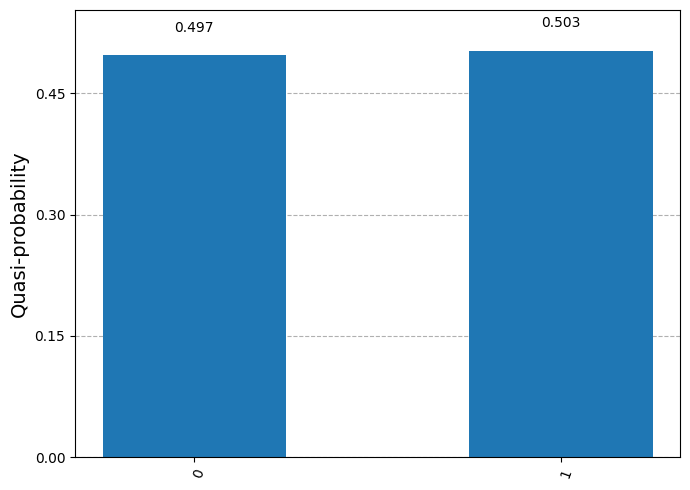

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepara qubit en estado |+>
qc.h(0)
# Alice ahora envía el cúbit a Bob
# pero Eve lo intercepta e intenta leerlo
qc.measure(0, 0)
qc.barrier()
# Eve luego le pasa esto a Bob 
# quien lo mide en base a X
qc.h(0)
qc.measure(0,0)

# Dibujar y simular el circuito
display(qc.draw('mpl'))
aer_sim = AerSimulator()
result = aer_sim.run(transpile(qc, aer_sim)).result()
plot_distribution(result.get_counts())

Podemos ver aquí que Bob ahora tiene un 50% de probabilidad de medir `1`, y si lo hace, él y Alice sabrán que hay algo mal con su canal.

El protocolo de distribución cuántica de claves consiste en repetir este proceso suficientes veces para que un espía tenga una probabilidad despreciable de salirse con la suya al interceptar. El protocolo es, en líneas generales, el siguiente:

**- Paso 1**

Alice elige una cadena de bits aleatorios, por ejemplo:

`1000101011010100`

Y una elección aleatoria de base para cada bit:

`ZZXZXXXZXZXXXXXX`

Alice mantiene esta información privada.

**- Paso 2**

Luego, Alice codifica cada bit en una cadena de qubits usando la base que eligió; esto significa que cada qubit está en uno de los estados $|0\rangle$, $|1\rangle$, $|+\rangle$ o $|-\rangle$, elegidos aleatoriamente. En este caso, la cadena de qubits se vería así:

$$
|1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

Este es el mensaje que ella envía a Bob.

**- Paso 3**

Bob mide cada qubit de forma aleatoria; por ejemplo, podría usar las siguientes bases:

`XZZZXZXZXZXZZZXZ`

Y Bob mantiene en privado los resultados de sus mediciones.

**- Paso 4**

Luego, Bob y Alice comparten públicamente qué base usaron para cada qubit. Si Bob midió un qubit en la misma base en la que Alice lo preparó, utilizan ese bit para formar parte de su clave secreta compartida; en caso contrario, descartan la información de ese bit.

**- Paso 5**

Finalmente, Bob y Alice comparten una muestra aleatoria de sus claves, y si las muestras coinciden, pueden estar seguros (con un pequeño margen de error) de que la transmisión fue exitosa.



## 3. Ejemplo en Qiskit: Sin Intercepción

Primero veamos cómo funciona el protocolo cuando nadie está escuchando; luego veremos cómo Alice y Bob pueden detectar a un espía. Como siempre, comencemos importando todo lo que necesitamos:

Para generar claves pseudoaleatorias, usaremos la función `randint` de la biblioteca numpy. Para asegurarnos de que puedas reproducir los resultados de esta página, estableceremos la semilla en 0:


In [4]:
np.random.seed(seed=0)

Llamaremos `n` a la longitud del mensaje inicial de Alice. En este ejemplo, Alice enviará un mensaje de 100 qubits de longitud:


In [5]:
n = 100

### 3.1 Paso 1:

Alice genera su conjunto aleatorio de bits:


In [6]:
np.random.seed(seed=0)
n = 100
## Paso 1
# Alice genera bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


Por el momento, el conjunto de bits '`alice_bits`' solo es conocido por Alice. Iremos llevando un seguimiento de qué información es conocida solo por Alice, cuál es conocida solo por Bob, y cuál ha sido enviada a través del canal de Eve, en una tabla como esta:

| Conocimiento de Alice | Canal de Eve | Conocimiento de Bob |
|:---------------------:|:------------:|:--------------------:|
|      alice_bits       |              |        &nbsp;        |

### 3.2 Paso 2:

Alice elige codificar cada bit en un qubit usando al azar la base $X$ o la base $Z$, y guarda la elección para cada qubit en `alice_bases`. En este caso, un `0` significa "preparar en la base $Z$", y un `1` significa "preparar en la base $X$":

In [7]:
np.random.seed(seed=0)
n = 100
## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Alice también mantiene esta información en privado:

| Conocimiento de Alice | Canal de Eve | Conocimiento de Bob |
|:---------------------:|:------------:|:--------------------:|
|      alice_bits       |              |                      |
|     alice_bases       |              |        &nbsp;        |

La función `encode_message`, que aparece a continuación, crea una lista de `QuantumCircuits`, cada uno representando un solo qubit en el mensaje de Alice:

In [45]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Preparar qubit en base Z
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Preparar qubit en base X
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [46]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

Podemos ver que el primer bit en `alice_bits` es `0`, y la base en la que lo codifica es la base $X$ (representada por `1`):


In [47]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


Y si observamos el primer circuito en `message` (que representa el primer qubit en el mensaje de Alice), podemos verificar que Alice ha preparado un qubit en el estado $|+\rangle$:

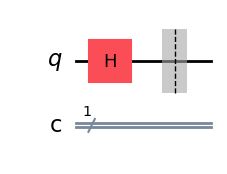

In [48]:
message[0].draw('mpl')

Como otro ejemplo, podemos ver que el cuarto bit en `alice_bits` es `1`, y está codificado en la base $Z$. Alice prepara el qubit correspondiente en el estado $|1\rangle$:

bit = 0
basis = 0


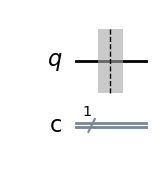

In [94]:
n=33
print('bit = %i' % alice_bits[n])
print('basis = %i' % alice_bases[n])
message[n].draw('mpl')

Este mensaje de qubits es luego enviado a Bob a través del canal cuántico de Eve:

| Conocimiento de Alice | Canal de Eve | Conocimiento de Bob |
|:---------------------:|:------------:|:--------------------:|
|      alice_bits       |              |                      |
|     alice_bases       |              |                      |
|       message         |    message   |       message        |

### 3.3 Paso 3:

Luego, Bob mide cada qubit en la base $X$ o $Z$ al azar y guarda esta información:


In [13]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Paso 3
# Decide qué base utilizar para la medición:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


`bob_bases` almacena la elección de Bob sobre en qué base mide cada qubit.

| Conocimiento de Alice | Canal de Eve | Conocimiento de Bob |
|:---------------------:|:------------:|:--------------------:|
|      alice_bits       |              |                      |
|     alice_bases       |              |                      |
|       message         |    message   |       message        |
|                       |              |     bob_bases        |

A continuación, la función `measure_message` aplica la medición correspondiente y simula el resultado de medir cada qubit. Almacenamos los resultados de las mediciones en `bob_results`.

In [14]:
def measure_message(message, bases):
    measurements = []
    for q in range(n):
        if bases[q] == 0: # medición en base Z
            message[q].measure(0,0)
        if bases[q] == 1: # medición en base X
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = AerSimulator()
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [15]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Paso 3
# Decide qué base utilizar para la medición:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

Podemos ver que al circuito en `message[0]` (que representa el qubit 0) se le ha añadido una medición en la base $X$ por parte de Bob:

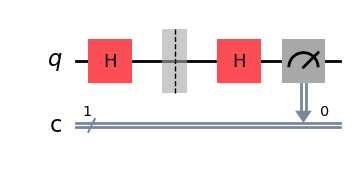

In [16]:
message[0].draw('mpl')

Dado que Bob, por casualidad, ha elegido medir en la misma base en la que Alice codificó el qubit, se garantiza que obtendrá el resultado `0`. Para el sexto qubit (mostrado abajo), la elección aleatoria de medición de Bob no coincide con la de Alice, y el resultado de Bob solo tiene un 50% de probabilidad de coincidir con el de Alice.

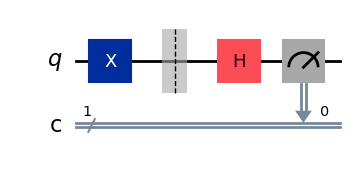

In [17]:
message[6].draw('mpl')

In [18]:
print(bob_results)

[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]


Bob mantiene sus resultados en privado.

| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |

### 3.4 Paso 4:

Después de esto, Alice revela (a través del canal de Eve) en qué base fue codificado cada qubit:

| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |

Y Bob revela en qué base midió cada qubit:

| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |
|     bob_bases         |     bob_bases      |        &nbsp;        |

Si Bob midió un bit en la misma base en la que Alice lo preparó, esto significa que la entrada correspondiente en `bob_results` coincidirá con la entrada correspondiente en `alice_bits`, y pueden usar ese bit como parte de su clave. Si midieron en bases diferentes, el resultado de Bob es aleatorio, y ambos descartan esa entrada. A continuación se muestra una función `remove_garbage` que hace esto por nosotros:


In [19]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # Si ambos usaron la misma base, 
            # añada esto a la lista de bits "buenas".
            good_bits.append(bits[q])
    return good_bits

Alice y Bob descartan los bits inútiles y utilizan los bits restantes para formar sus claves secretas:


In [20]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Paso 3
# Decide qué base utilizar para la medición:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Paso 4
#está devolviendo es una lista de objetos numpy.int32
#alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
#Salida: [np.int32(0), np.int32(1), np.int32(1), ...]

#Convertir todos esos valores a entero: np.int32 en un int.
alice_key = list(map(int, remove_garbage(alice_bases, bob_bases, alice_bits)))
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |
|     bob_bases         |     bob_bases      |                      |
|      alice_key        |                    |        &nbsp;        |


In [21]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Paso 3
# Decide qué base utilizar para la medición:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Paso 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |
|     bob_bases         |     bob_bases      |                      |
|     alice_key         |                    |      bob_key         |


### 3.5 Paso 5:

Finalmente, Bob y Alice comparan una selección aleatoria de los bits en sus claves para asegurarse de que el protocolo ha funcionado correctamente:


In [22]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # usar np.mod para asegurar que 
        # el bit que muestreamos siempre 
        # esté en el rango de la lista
        i = np.mod(i, len(bits))
        # pop(i) elimina el elemento de 
        # la lista en el índice 'i'
        sample.append(bits.pop(i))
    return sample

Tanto Alice como Bob transmiten esto públicamente y lo eliminan de sus claves porque ya no son secretos:

In [23]:
np.random.seed(seed=0)
n = 100

## Paso 1
#Alice genera bits
alice_bits = randint(2, size=n)

## Paso 2
# Crear una matriz que nos indique qué cúbits
# están codificados en qué bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Paso 3
# Decide qué base utilizar para la medición:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Paso 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Paso 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
#alice_sample = sample_bits(alice_key, bit_selection)
alice_sample = list(map(int,sample_bits(alice_key, bit_selection)))
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |
|     bob_bases         |     bob_bases      |                      |
|     alice_key         |                    |      bob_key         |
|     bob_sample        |    bob_sample      |     bob_sample       |
|    alice_sample       |   alice_sample     |    alice_sample      |


Si el protocolo ha funcionado correctamente sin interferencias, sus muestras deberían coincidir:


In [24]:
bob_sample == alice_sample

True

Si sus muestras coinciden, significa (con alta probabilidad) que `alice_key == bob_key`. ¡Ahora comparten una clave secreta que pueden usar para cifrar sus mensajes!

| Conocimiento de Alice | Canal de Eve       | Conocimiento de Bob |
|:---------------------:|:------------------:|:--------------------:|
|      alice_bits       |                    |                      |
|     alice_bases       |                    |                      |
|       message         |      message       |       message        |
|                       |                    |      bob_bases       |
|                       |                    |     bob_results      |
|                       |     alice_bases    |     alice_bases      |
|     bob_bases         |     bob_bases      |                      |
|     alice_key         |                    |      bob_key         |
|     bob_sample        |    bob_sample      |     bob_sample       |
|    alice_sample       |   alice_sample     |    alice_sample      |
|     shared_key        |                    |     shared_key       |


In [25]:
print(bob_key)
#print(alice_key)
print(list(map(int,alice_key)))
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## 4. Ejemplo en Qiskit: *Con* Intercepción

Ahora veamos cómo Alice y Bob pueden darse cuenta si Eve ha estado intentando espiar su mensaje cuántico. Repetimos los mismos pasos que en el caso sin interferencia, pero antes de que Bob reciba sus qubits, Eve intentará extraer algo de información de ellos. Establezcamos una semilla diferente para obtener un conjunto específico de resultados 'aleatorios' reproducibles:


In [26]:
np.random.seed(seed=3)

### 4.1 Paso 1:

Alice genera su conjunto de bits aleatorios:


In [27]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


### 4.2 Paso 2:

Alice codifica estos bits en las bases $Z$ y $X$ de forma aleatoria, y los envía a Bob a través del canal cuántico de Eve:


In [28]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


En este caso, el primer qubit en el mensaje de Alice está en el estado $|+\rangle$:


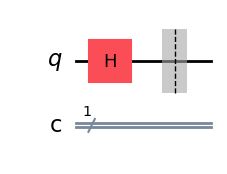

In [29]:
message[0].draw('mpl')

### ¡Intercepción!

¡Oh no! Eve intercepta el mensaje mientras pasa por su canal. Intenta medir los qubits usando una selección aleatoria de bases, de la misma manera en que lo hará Bob más adelante.


In [30]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interceptación!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


Podemos ver el caso del qubit 0 a continuación; la elección aleatoria de base de Eve no coincide con la de Alice, y esto cambiará el estado del qubit de $|+\rangle$ a un estado aleatorio en la base $Z$, con un 50% de probabilidad de ser $|0\rangle$ o $|1\rangle$:


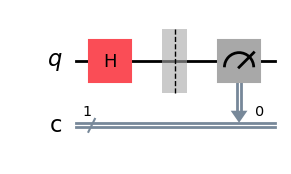

In [31]:
message[0].draw('mpl')

### 4.3 Paso 3:

Eve luego pasa los qubits a Bob, quien los mide al azar. En este caso, Bob eligió (por casualidad) medir en la misma base en la que Alice preparó el qubit. Sin la intervención de Eve, Bob tendría garantizado medir `0`, pero debido a que Eve intentó leer el mensaje, ahora tiene un 50% de probabilidad de medir `1` en su lugar.


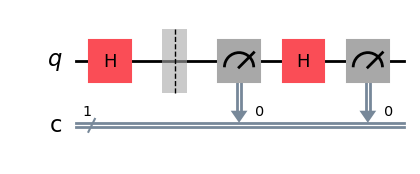

In [32]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interceptación!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Paso 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw('mpl')

### 4.4 Paso 4:

Bob y Alice revelan sus elecciones de base y descartan los bits inútiles:

In [33]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interceptación!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Paso 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Paso 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 Paso 5:

Bob y Alice comparan la misma selección aleatoria de sus claves para ver si los qubits fueron interceptados:


In [34]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interceptación!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Paso 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Paso 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Paso 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
#alice_sample = sample_bits(alice_key, bit_selection)
alice_sample = list(map(int,sample_bits(alice_key, bit_selection)))
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [35]:
bob_sample == alice_sample

False

¡Oh no! Las claves de Bob y Alice no coinciden. Sabemos que esto se debe a que Eve intentó leer el mensaje entre los pasos 2 y 3, y cambió los estados de los qubits. Para Alice y Bob, esto podría deberse al ruido del canal, pero en cualquier caso deben descartar todos los resultados e intentarlo de nuevo: el intento de interceptación de Eve ha fallado.

## 5. Análisis de Riesgo

Para este tipo de interceptación, en la que Eve mide todos los qubits, existe una pequeña probabilidad de que las muestras de Bob y Alice coincidan, y que Alice envíe su mensaje vulnerable a través del canal de Eve. Vamos a calcular esa probabilidad y ver qué tan riesgosa es la distribución cuántica de claves.

- Para que Alice y Bob usen el resultado de un qubit, ambos deben haber elegido la misma base. Si Eve también elige esta base, interceptará con éxito ese bit sin introducir ningún error. Hay un 50% de probabilidad de que esto ocurra.
- Si Eve elige la *base incorrecta*, es decir, una base diferente a la de Alice y Bob, todavía hay un 50% de probabilidad de que Bob mida el valor que Alice intentaba enviar. En ese caso, la interceptación también pasa desapercibida.
- Pero si Eve elige la *base incorrecta*, es decir, diferente a la de Alice y Bob, también hay un 50% de probabilidad de que Bob **no** mida el valor que Alice intentaba enviar, y esto **sí** introducirá un error en sus claves.

<img src="qkd_risk.svg">

Si Alice y Bob comparan 1 bit de sus claves, la probabilidad de que los bits coincidan es $0.75$, y si eso ocurre no notarán la interceptación de Eve. Si comparan 2 bits, hay una probabilidad de $0.75^2 = 0.5625$ de que la interceptación no sea detectada. Podemos ver que la probabilidad de que Eve no sea detectada se puede calcular a partir del número de bits ($x$) que Alice y Bob decidan comparar:

$$ P(\text{no detectado}) = 0.75^x $$

Si decidimos comparar 15 bits, como hicimos antes, existe una probabilidad del 1.3% de que Eve no sea detectada. Si este riesgo es demasiado alto para nosotros, podríamos comparar 50 bits y reducir la probabilidad a un 0.00006% de ser espiados sin saberlo.

Puedes volver a ejecutar el protocolo ejecutando la celda siguiente. Prueba cambiando `sample_size` a un valor bajo y observa qué tan fácil es para Eve interceptar las claves de Alice y Bob.


In [36]:
np.random.seed(seed=3)
## Paso 1
alice_bits = randint(2, size=n)
## Paso 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interceptación!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Paso 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Paso 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Paso 5
sample_size = 15 # Cambia esto a algo más bajo y comprueba si 
                 # Eve puede interceptar el mensaje sin que Alice
                 # y Bob se enteren
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


In [37]:
import qiskit
qiskit.__version__

'2.0.0'